<h3 align = center>PART I </h3>

### Outline: <br>
<li> Introduction </li> <br>
<li> Data exploration </li> <br>
<li> EDA: Univariate analysis </li> <br>
<li> EDA: Bivariate analysis </li> <br>
<li> Model </li> <br>
<li> Feature engineering </li> <br>
<li> Results and conclusion</li> <br>

#### 1. Introduction <br>
This report presents my case study for ILO’s “written test” challenge. Such study constitutes my submission to ILO for a step of my recruitment process for the internship position ”Data Science and Transformative Technology for Strategic Compliance”. <br>
<br>
Statement of Work <br>
<br>
The goal of this challenge is to predict the chances of graduate admissions. The dataset contains several parameters which are generally considered important during the application for Master Programs. The parameters include: GRE Scores (out of 340); TOEFL Scores (out of 120); University Rating (out of 5); Statement of Purpose and Letter of Recommendation Strength (out of 5); Undergraduate GPA (out of 10); Research Experience(either 0 or 1); Chance of Admit (ranging from 0 to 1). The variable we want to predict is Chance of Admit; the rest are predictor variables or covariates. <br>
<br>

In [566]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# import ML libraries
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings("ignore")

#### 2. Data exploration
I am provided with one dataset encoded in .csv format. Each entry in the data contains information about parameters which are required for admission to the universities.  


In [567]:
data = pd.read_csv('./data/Dataset.csv')
data.head(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


First, I start by checking the shape for the dataset. We can see that it contains 400 entries and 9 features.

In [568]:
data.shape

(400, 9)

We can continue with looking for missing values in the dataset. We may see that there is no missing values.

In [569]:
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

Next I checked datatypes and convert them if necessary

In [570]:
data.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

As we can see there are 5 int and 4 float values <br> 
Lets check for outliers using Z-score method and remove or transform features if required. 

In [571]:
from scipy import stats
z = np.abs(stats.zscore(data))
data =data[(z < 3).all(axis=1)]

I choose to remove it because there is only one outlier. If many outliers observed one should be careful and choose other methods such as transformation of the feature with many outliers. 

In [572]:
data.shape

(399, 9)

For the convenience of further analysis I renamed the features with the simple names as follows:

In [573]:
new_names = {'Serial No.': 'no',
            'GRE Score': 'gre',
            'TOEFL Score': 'toefl',
            'University Rating': 'rating',
            'SOP': 'sop',
            'LOR ': 'rec',
            'CGPA': 'gpa',
            'Research': 'research',
            'Chance of Admit ': 'y'}

data = data.rename(columns=new_names)
data.columns

Index(['no', 'gre', 'toefl', 'rating', 'sop', 'rec', 'gpa', 'research', 'y'], dtype='object')

#### 3. Univariate analysis: what factors are important in graduate admissions?

Lets start our analysis with basic statistics.

In [574]:
data.describe()

,no,gre,toefl,rating,sop,rec,gpa,research,y
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,200.854637,316.849624,107.431078,3.092732,3.401003,3.456140,8.603434,0.546366,0.725263
std,115.541413,11.457040,6.062459,1.140362,1.007933,0.896647,0.590200,0.498471,0.141613
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,7.200000,0.000000,0.340000
25%,101.500000,308.500000,103.000000,2.000000,2.500000,3.000000,8.175000,0.000000,0.640000
50%,201.000000,317.000000,107.000000,3.000000,3.500000,3.500000,8.620000,1.000000,0.730000
75%,300.500000,325.000000,112.000000,4.000000,4.000000,4.000000,9.065000,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


1) Looking for the mean values we can see different scales which should be rescaled when training model. <br>
2) We can see a good correspondence between 'mean', 'min', 'max' values of the features. They are roughly within 3 standard deviations apart from mean, which implies that the features distributed normally. <br>
3) We can see that pictorially using histogram plots

In [575]:
len(data.no.unique())

399

We can observe that the first feature - "no" is unique identifier and does not have any informative power. Therefore, for feature engineering purposes, it should be dropped.

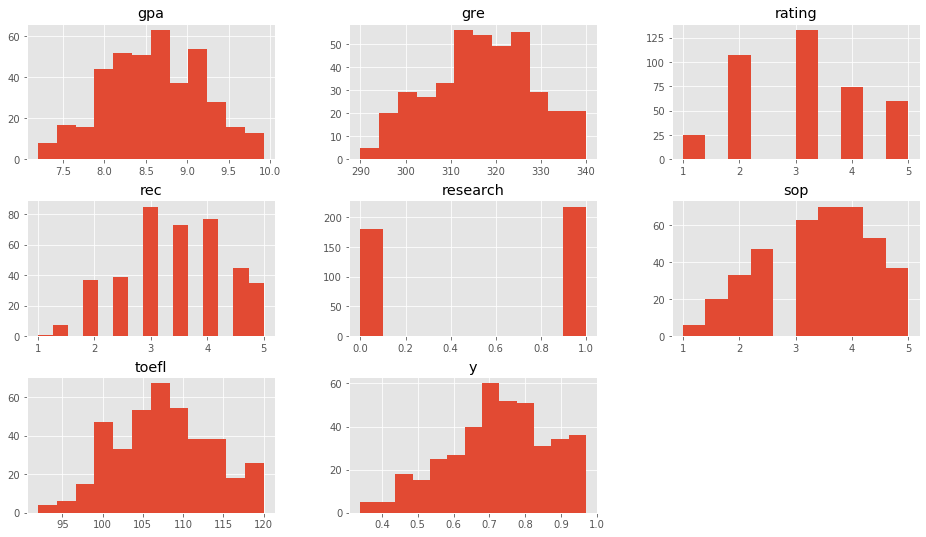

In [576]:
data = data.drop('no', axis=1)
data.hist(bins='auto', figsize=(16,9));

Furthermore, lets look how symmetrical is the distribution for the features. The degree of distortion - skewness could be calculated using pandas agg function. <br>
The rule of thumb: <br> 
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.<br>
- If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.<br>
- If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.<br>

https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa

In [577]:
data.agg(['skew'])

,gre,toefl,rating,sop,rec,gpa,research,y
skew,-0.06644,0.053819,0.174875,-0.278424,-0.109427,-0.019763,-0.18697,-0.33831


We can see the features more or less symmetrical with 'y' ('Chance of Admit') being close to moderately skewed range. That is the point to remember when training the model.<br>
Next, I am going to look how target variable 'y' depends on other variables. I have 3 features ('sop', 'rec', 'rating') ranging between 1 to 5,  1 feature ('research') with 2 values. To make a fair comparison, I am going to divide the remaining continous features ('gre', 'toefl', 'gpa') into 5 categories or intervals too.

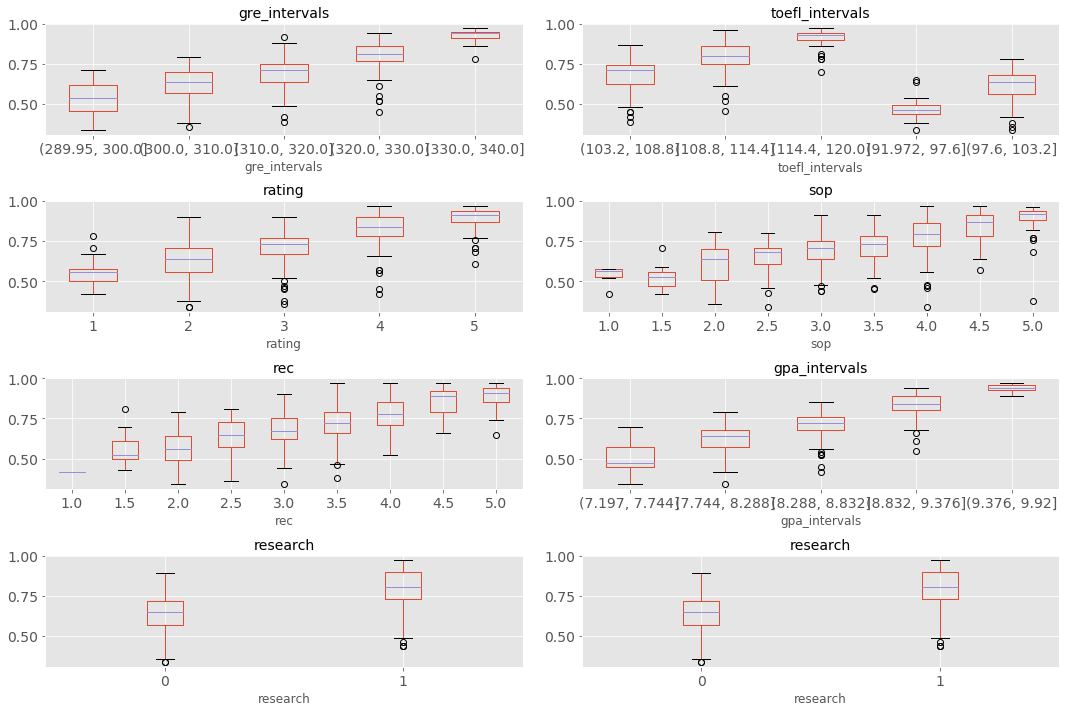

In [578]:
cols = ['gre', 'toefl', 'rating', 'sop', 'rec', 'gpa', 'research']
fig, ax  = plt.subplots(4,2,figsize = (10,8))
count = 0
for i in range(4):
    for j in range(2):
        if count+j < 6:
            s = cols[count+j]
        else:
            s = cols[-1]
        if s in ['gre', 'toefl', 'gpa']:
            data[s+'_intervals'] = pd.cut(data[s], bins=5).astype(str)
            data.boxplot(column='y',by=s+'_intervals', grid=True,ax=ax[i][j], fontsize=14)
            ax[i][j].set_title(s+'_intervals',fontsize = 14)
        else:
            data.boxplot(column='y',by=s, grid=True,ax=ax[i][j], fontsize=14)
            ax[i][j].set_title(s,fontsize = 14)
        fig = plt.gcf()
        fig.set_size_inches(15,10)
        plt.tight_layout()
        plt.suptitle('')
    count = count+j+1
data = data.drop(['gre_intervals', 'toefl_intervals', 'gpa_intervals'], axis=1)

- We can immediately from the plots that the chances for admission is higher with higher 'gpa', 'gre', 'toefl' scores. <br>
- Students with better 'sop' and 'rec' also have better chance in getting to the universities <br>
- Moreover, lower rated universities have higher admission probabilities <br>
- Being involved research will increase chances of getting admission. Lets see how the last point reveals itself in regard to other features.

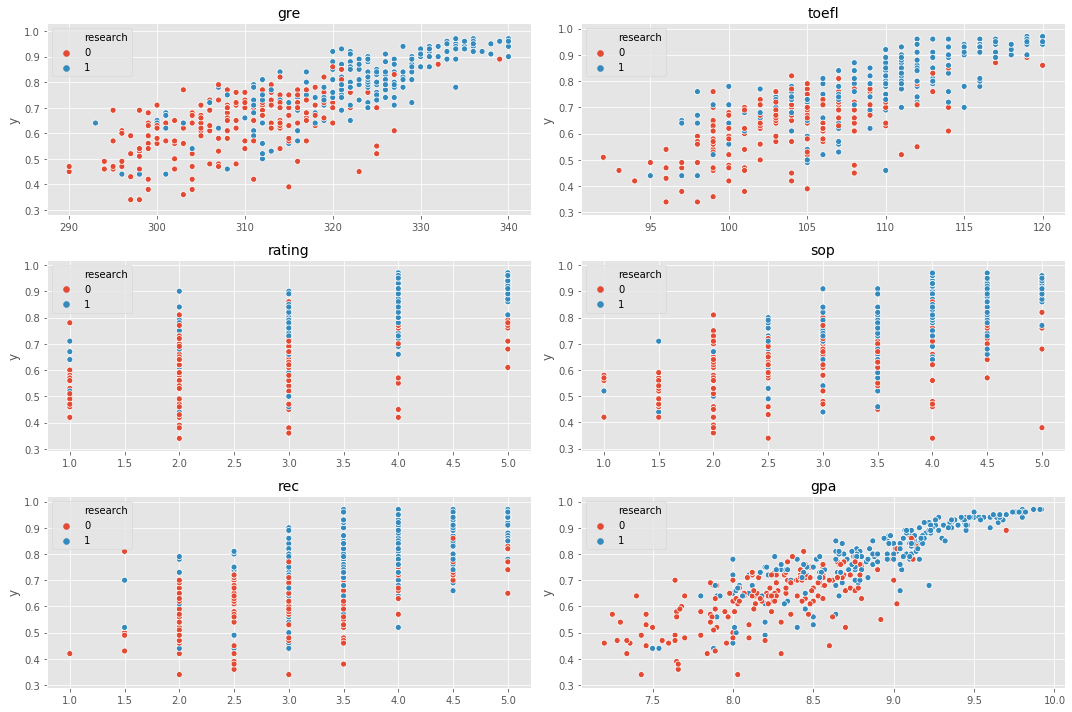

In [579]:
cols = ['gre', 'toefl', 'rating', 'sop', 'rec', 'gpa']
fig, ax  = plt.subplots(3,2,figsize = (10,8))
count = 0
for i in range(3):
    for j in range(2):
        s = cols[count+j]
        sns.scatterplot(data[s].values,y = data.y,
                     hue = 'research',data = data,ax = ax[i][j])
        ax[i][j].set_title(s,fontsize = 14)
        fig = plt.gcf()
        fig.set_size_inches(15,10)
        plt.tight_layout()
    count = count+j+1  

- We can immediately see that most of the researchers (entries with research score equals to 1) lay in the right side of the graph which means they have better scores and higher chances compared to non-researchers. 

#### 4. Bivariate analysis: how are these parameters interrelated among themselves?

In this section I am going to look how the factors making up the dataset are interrelated among themselves. We can start by plotting the features pairwise and observe their connectedness.

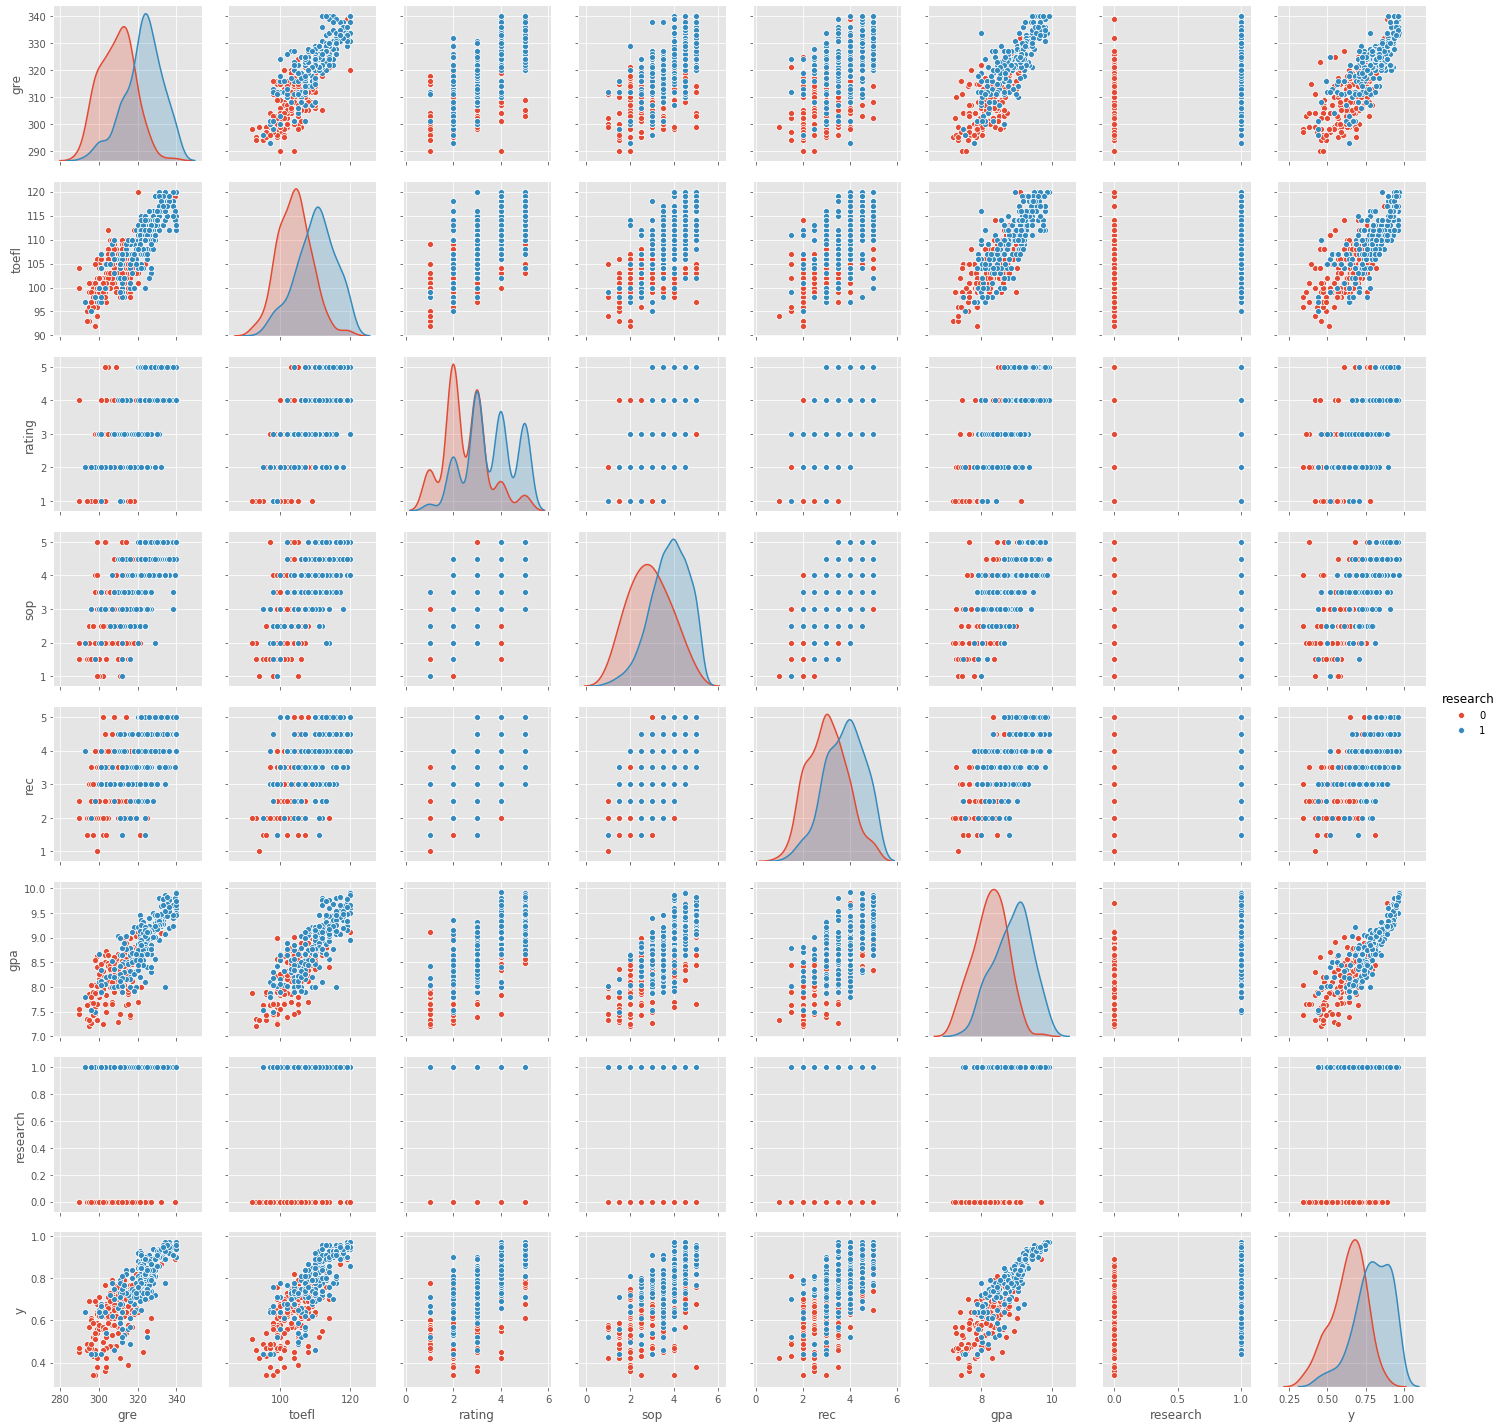

In [580]:
sns.pairplot(data=data, hue='research');

- It is clear that GPA, TOEFL and GRE score are linearly related to each-other. So students with higher GPA perform better during GRE and TOEFL exams than students with lower GPA. 
- If looking diagonalwise one can see the distribution for research students has slightly shifted to the right which means they tend to score higher in these exams. From 'rating' it should be also noted that there are less research students as applicants for top rated universities than average or less rated universities.
- To quantify the relatedness between different factors we use correlation function in the following

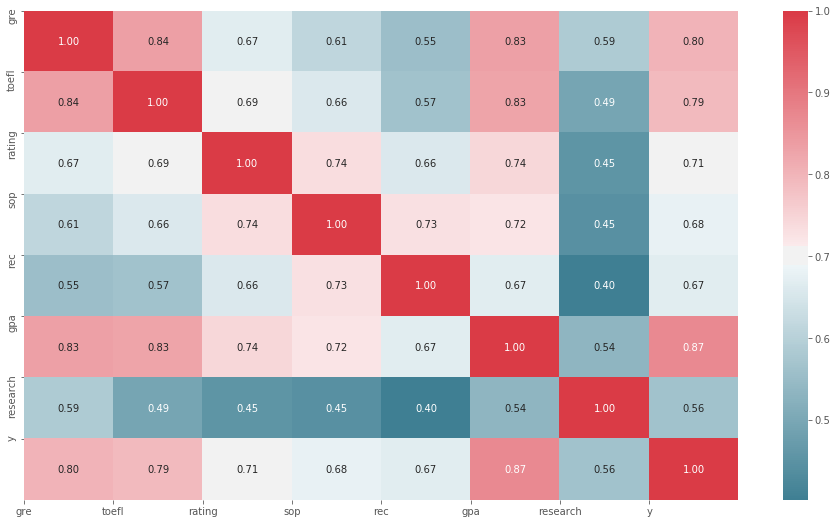

In [581]:
def heat_map(data):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(16, 9))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.show()

heat_map(data)

As we have already seen in the pairplot there is a good correlation between all factors. Since the variables are highly correlated I am using partial correlation function in order to look for true correlation between two variables by removing the effect of others. 

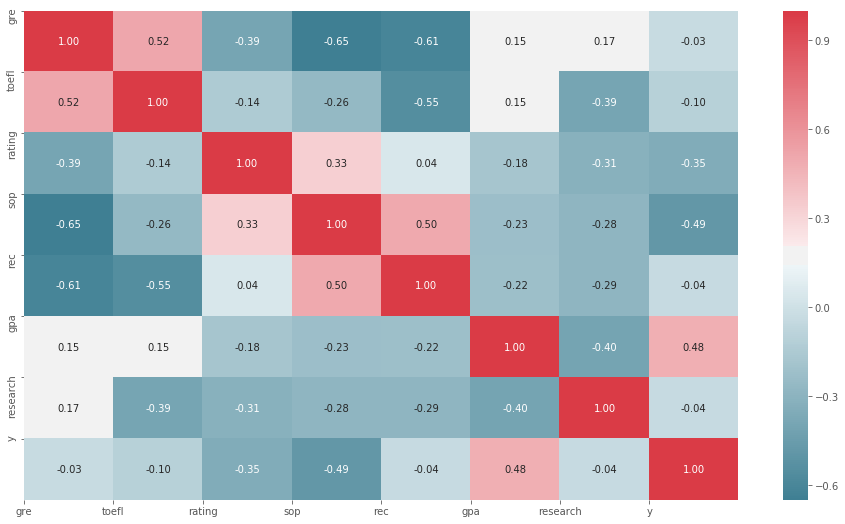

In [582]:
from scipy import stats

def partial_corr(data):
    
    p_corr_matrix = np.zeros((data.shape[1], data.shape[1]))
    for i, column1 in enumerate(data):
        for j, column2 in enumerate(data):
            control_var = np.delete(np.arange(data.shape[1]), [i,j])
            if i == j:
                p_corr_matrix[i,j] = 1
                continue
            data_control_var = data.iloc[:, control_var]
            data_column1 = data[column1].values
            data_column2 = data[column2].values
            fit1 = LinearRegression(fit_intercept=True)
            fit2 = LinearRegression(fit_intercept=True)
            fit1.fit(data_control_var, data_column1)
            fit2.fit(data_control_var, data_column2)
            res1 = data_column1 - (np.dot(data_control_var, fit1.coef_) + fit1.intercept_)
            res2 = data_column2 - (np.dot(data_control_var, fit2.coef_) + fit2.intercept_)
            p_corr_matrix[i, j] = stats.pearsonr(res1, res2)[0]
    return pd.DataFrame(p_corr_matrix, columns=data.columns, index=data.columns)

heat_map(partial_corr(data))

We can see there is a positive correlation between 'gre' and 'toefl', 'gpa' and 'research'. Moreover the feature 'sop' positively correlated to 'ranking' and 'recommendation letter', and negatively correlated with 'gre'. 

#### 5. Model for predicting: how your model can help predict one’s chances of admission.

Once we gained preliminary understanding about our dataset we can start building a prediction model that will help us to predict one's chances of admission. For this purpose, I will use the following regression models: Linear regression, Ridge, Lasso regression, Decision tree regressor, Random forrest and choose the one with the lowest mean squared error.   

In [609]:
class bestEstimator:
    
    def __init__(self, algo, algo_name, train_size=0.7):
        self.algo = algo
        self.algo_name = algo_name
        self.train_size = train_size
    
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, 
                                                                                self.Y, 
                                                                                train_size = self.train_size,
                                                                                random_state=0)
        self.algo.fit(self.X_train, self.Y_train)
        return self
    
    def predict(self, test=False):
        if test:
            return self.algo.predict(self.X_test)
        else:
            return self.algo.predict(self.X_train)
    
    def metrics(self, test= False):
        if test:
            return mean_squared_error(self.Y_test, self.predict(test)), r2_score(self.Y_test, self.predict(test))
        else:
            return mean_squared_error(self.Y_train, self.predict()), r2_score(self.Y_train, self.predict())

Seprate data into X and Y components:

In [610]:
X = data.drop('y', axis=1)
Y = data.y

I split dataset into 70% train data and 30% test data by settin train_size=0.7

In [611]:
estimators = [('OLS', LinearRegression()),
             ('Ridge', RidgeCV(alphas = np.logspace(-10,10,21), cv=10)),
             ('Lasso', LassoCV(alphas = np.logspace(-10,10,21), cv=10)),
             ('Random Forrest', RandomForestRegressor(random_state=0)),
             ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=17))]

scores_train = []
scores_test = []

names = []

for name, estimator in estimators:
    model = bestEstimator(estimator, name)
    model.fit(X, Y)
    names.append(name)
    scores_train.append(model.metrics())
    scores_test.append(model.metrics(test=True))
    
scores_test = np.array(scores_test).transpose()
scores_table_test = pd.DataFrame({'Model_name': names,
                            'MSE_test': scores_test[0],
                            'R2_test': scores_test[1]})

scores_train = np.array(scores_train).transpose()
scores_table_train = pd.DataFrame({'Model_name': names,
                            'MSE_train': scores_train[0],
                            'R2_train': scores_train[1]})

scores_table = scores_table_train.merge(scores_table_test, how='left', on='Model_name')

In [612]:
scores_table.sort_values(by='MSE_train', ascending=True)

,Model_name,MSE_train,R2_train,MSE_test,R2_test
4,DecisionTreeRegressor,2.208952e-34,1.000000,0.009566,0.462382
3,Random Forrest,9.398495e-04,0.955142,0.005228,0.706195
0,OLS,3.767925e-03,0.820163,0.004587,0.742179
2,Lasso,3.768229e-03,0.820148,0.004594,0.741783
1,Ridge,3.770692e-03,0.820031,0.004594,0.741783


We can see from the table above that Random forrest and Decision tree performs well (with less mean squared error) on a training set while they fail to show the same performance on a test set. <br>
Linear models on the other hand perform almost similar on the train and test set. <br> 
In general, all models show better performance in the training set which is an indication of overfitting. Overfitting can be reduced by reducing dimensionality or by tuning some parameters for some models which I am going to do next. 

##### 5.1. Individual analysis: Random Forest

In [614]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.7, shuffle=True, random_state=17)

kf = KFold(n_splits=5, shuffle=True, random_state=17)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

I am going to tune important parameters for random forrest (max features, num of estimators, max depth) to imporove models performance on dataset. I will use GridSearch with cross validation to find optimum.

In [615]:
frst_params = {'max_features': [1, 2, 4, 6, 7],
               'n_estimators': [5, 25, 55, 100, 150],
               'max_depth': [1, 5, 8, 12, 20, 30]}

frst = RandomForestRegressor(random_state=17)
frst_grid = GridSearchCV(frst, frst_params, scoring = scorer, cv = kf, n_jobs=-1)
frst_grid.fit(X_train, Y_train)

print("Train error: ", mean_squared_error(Y_train, frst_grid.predict(X_train)), \
      "\n", "Test error: ", mean_squared_error(Y_test, frst_grid.predict(X_test)))

Train error:  0.0025372021997761922 
 Test error:  0.004417057952236573


We can see the random forrest model has imporoved already. Its error on a test set has dropped from 5.22e-03 to 4.4e-03. To improve model's performance and also to reduce dimensionality by removing unnecessary features I am going to scale features with MinMax scaler.

In [616]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [617]:
frst_grid.fit(X_train, Y_train)

print("Train error: ", mean_squared_error(Y_train, frst_grid.predict(X_train)), \
      "\n", "Test error: ", mean_squared_error(Y_test, frst_grid.predict(X_test)))

Train error:  0.0025351515273170947 
 Test error:  0.004398455294339292


In [618]:
importance = frst_grid.best_estimator_.feature_importances_
feature_table = pd.DataFrame({"Importance": importance})
feature_table["Features"] = X.columns
feature_table.sort_values(by="Importance", ascending= False, inplace=True)
feature_table

,Importance,Features
5,0.321292,gpa
1,0.242942,toefl
0,0.222806,gre
2,0.080099,rating
6,0.057902,research
3,0.049608,sop
4,0.025351,rec


The random forrest model score has improved a bit after scaling the features. I have also made a table for feature importances. As you can see according to the model the most important features with higher chance of admission are 'GPA', 'TOEFL' and 'GRE' scores.  

##### 5.2. Individual analysis: Linear Regression

Here I am going to consider the linear regression model as our prediction model and try to improve its performance.

In [619]:
lin_reg  = LinearRegression()
lin_reg.fit(X_train, Y_train)  #scaled

print("Train error: ", mean_squared_error(Y_train, lin_reg.predict(X_train)), 
      "\n", "Test error: ", mean_squared_error(Y_test, lin_reg.predict(X_test)))

coefs = lin_reg.coef_
coefs_table = pd.DataFrame({"Coeffients": coefs})
coefs_table["Features"] = X_train.columns
coefs_table.sort_values(by="Coeffients", ascending= False, inplace=True)
coefs_table

Train error:  0.003984762795582381 
 Test error:  0.004183679434684591


,Coeffients,Features
5,0.314458,gpa
1,0.084800,toefl
0,0.083703,gre
4,0.048631,rec
2,0.031660,rating
6,0.026745,research
3,-0.021046,sop


- It should be noted that linear model performs better in terms of test error than random forrest. It has relatively similar train and test errors and therefore less overfitting.
- It is strange that the model gives a negative coefficient to 'sop' feature. To analyze it further we need to look for a statistical symmary of regression model. This can be done using statsmodels library. 

In [620]:
from statsmodels.api import OLS, add_constant

X_train_const = add_constant(X_train) 
lm = OLS(Y_train,X_train_const).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     144.3
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           1.42e-87
Time:                        09:29:54   Log-Likelihood:                 374.89
No. Observations:                 279   AIC:                            -733.8
Df Residuals:                     271   BIC:                            -704.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4255      0.013     33.022      0.000       0.400       0.451
gre            0.0837      0.035      2.392      0.017       0.015       0.153
toefl          0.0848      0.036      2.359      0.019       0.014       0.156
rating         0.0317      0.024      1.321      0.188      -0.016       0.079
sop           -0.0210      0.027     -0.785      0.433      -0.074       0.032
rec            0.0486      0.026      1.858      0.064      -0.003       0.100
gpa            0.3145      0.041      7.760      0.000       0.235       0.394
research       0.0267      0.010      2.796      0.006       0.008       0.046
==============================================================================
Omnibus:                       64.467   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.131
Skew:                          -1.163   Prob(JB):                     2.03e-29
Kurtosis:                       5.440   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking for p-values of features we can see that some of them higher than significance level of 0.05. They are 'sop', 'rating', 'rec'. I am going to remove 'sop' and 'rating' to see how it effects the linear model's performance.  

In [621]:
X_train_const = X_train_const.drop(['sop', 'rating'], axis=1)

lm = OLS(Y_train,X_train_const).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     201.8
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           1.76e-89
Time:                        09:35:15   Log-Likelihood:                 373.94
No. Observations:                 279   AIC:                            -735.9
Df Residuals:                     273   BIC:                            -714.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4215      0.013     33.671      0.000       0.397       0.446
gre            0.0881      0.035      2.530      0.012       0.020       0.157
toefl          0.0865      0.036      2.427      0.016       0.016       0.157
rec            0.0496      0.023      2.148      0.033       0.004       0.095
gpa            0.3225      0.038      8.396      0.000       0.247       0.398
research       0.0266      0.010      2.787      0.006       0.008       0.045
==============================================================================
Omnibus:                       65.878   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.004
Skew:                          -1.181   Prob(JB):                     1.78e-30
Kurtosis:                       5.491   Cond. No.                         19.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By removing 'sop' and 'rating' p-value for 'rec' has also dropped below the significance level. This can be understood by looking a correlation plot above where it shows that these 3 features are positively correlated. 

In [622]:
X_train = X_train.drop(['sop', 'rating'], axis=1)
X_test = X_test.drop(['sop', 'rating'], axis=1)

In [623]:
lin_reg  = LinearRegression()
lin_reg.fit(X_train, Y_train)  #scaled

print("Train error: ", mean_squared_error(Y_train, lin_reg.predict(X_train)), 
      "\n", "Test error: ", mean_squared_error(Y_test, lin_reg.predict(X_test)))

coefs = lin_reg.coef_
coefs_table = pd.DataFrame({"Coeffients": coefs})
coefs_table["Features"] = X_train.columns
coefs_table.sort_values(by="Coeffients", ascending= False, inplace=True)
coefs_table

Train error:  0.0040120388612398476 
 Test error:  0.0041505869809429


,Coeffients,Features
3,0.322482,gpa
0,0.088057,gre
1,0.086546,toefl
2,0.049593,rec
4,0.026587,research


So the mean squared error for test set has improved only very slightly (from 0.004183 to 0.004150) and we don't have negative coefficients anymore. 

#### 6. Conclusion

The goal of this written test is to do explanotary data analysis on the given dataset, and to implement a regression model for predicting one's chances of university admission. I started by exploring the structure of dataset, cheking for missing values, handling outliers. I used statistical summaries and plotting techniques to explore the variables and their importance to the chance of admission. Moreover, I used different regression models and evaluted their performance using metrics such as mean-squared error, and R-squared. I choosed the models that are good at predicting and tried to improve their performance by means of hyperparameter tuning and dimensionality reduction. <br>
There are still several explorations, adjustments and improvements that can be made on this case study, but unfortunately I did not have enough time available till expected submission time. The next actions I would pursure at this point would be to use bottom-up approach by starting with a single feature (e.g. CGPA) and improve my baseline model by adding more features if necessary. Moreover, since a 'research' feature is one of the important features as we saw in EDA (research students do better than non-researchers) I would devise a model which treats research and non-research students separately and predict chances of admission accordingly. 